In [7]:
import sys
import io
import PIL
import PIL.Image as Image
import PIL.ImageOps  
sys.path.append("../")

from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
from fastapi import FastAPI, Request
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import uvicorn
from utils.model_definition import build_densenet_based_model

import time
from prometheus_client import Counter, Gauge
from prometheus_fastapi_instrumentator import Instrumentator




In [ ]:
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)
# Define counters for API usage
api_usage_counter = Counter("api_usage", "API usage counter", ["client_ip"])

Instrumentator().instrument(app).expose(app)

# Define gauges for API processing time
api_time_gauge = Gauge("api_time", "API processing time", ["client_ip"])
api_time_per_char_gauge = Gauge("api_time_per_char", "API processing time per character", ["client_ip"])

def load_model():
    model = build_densenet_based_model()
    model.load_weights("/../weights/densenet_weights.h5")
    return model

def preprocess_image(image):
    #perform some preprocessing
    image = tf.image.resize(image, (224, 224))
    return image

def predict_label(image, model):
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    
    # Make the prediction
    prediction = model.predict(preprocessed_image)
    
    return prediction
    

def predict(request:Request, file: UploadFile = File(...)):
    start_time = time.time()
    
    from PIL import Image

    image_path = "data/original/benain/image.jpg"
    image = Image.open(image_path)
    image.show()
    
    # Get client IP address
    client_ip = request.client.host
    
    # Increment API usage counter
    api_usage_counter.labels(client_ip).inc()

   
    pil_image = PIL.Image.open(io.BytesIO(image))

    image = preprocess_image(pil_image)

    model = load_model()

    label = predict_label(image, model)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    # Set API processing time gauges
    api_time_gauge.labels(client_ip).set(total_time)
    api_time_per_char_gauge.labels(client_ip).set(total_time / len(file.filename))
    
    return {"label": label}

In [25]:
image_path = "../data/Original/Pro/WBC-Malignant-Pro-001.jpg"
image = Image.open(image_path)
image = tf.image.resize(image, (224, 224))

In [27]:
image.shape

TensorShape([224, 224, 3])

In [26]:
image = tf.reshape(image, (256, 256, 3))

2024-05-16 23:15:55.148664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 150528 values, but the requested shape has 196608


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 150528 values, but the requested shape has 196608 [Op:Reshape]

In [16]:
def load_model():
    model = build_densenet_based_model()
    model.load_weights("../weights/densenet_weights.h5")
    return model

In [17]:
model = load_model()

In [46]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Open the image using PIL
pil_image = Image.open(image_path)



In [ ]:
256*256 , 224*224*3
img_size = [256,256]
tensor_image = tf.convert_to_tensor(pil_image)
car_img = tf.image.decode_jpeg(tensor_image, channels=3)
print(car_img.shape)
car_img = tf.image.resize(car_img, img_size)

car_img = tf.cast(car_img, tf.float32) / 255.0
print(car_img.shape)

ValueError: Tensor conversion requested dtype string for Tensor with dtype uint8: <tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[169, 185, 200],
        [173, 189, 202],
        [183, 197, 208],
        ...,
        [221, 223, 218],
        [221, 223, 218],
        [222, 224, 219]],

       [[167, 180, 197],
        [169, 182, 198],
        [175, 189, 202],
        ...,
        [221, 223, 218],
        [221, 223, 218],
        [221, 223, 218]],

       [[163, 174, 196],
        [164, 177, 196],
        [168, 181, 198],
        ...,
        [222, 225, 218],
        [222, 224, 219],
        [223, 225, 220]],

       ...,

       [[224, 230, 228],
        [225, 231, 229],
        [227, 233, 229],
        ...,
        [231, 237, 233],
        [226, 232, 230],
        [228, 234, 232]],

       [[224, 230, 228],
        [225, 231, 229],
        [227, 233, 229],
        ...,
        [230, 236, 236],
        [227, 235, 237],
        [226, 234, 236]],

       [[225, 231, 229],
        [225, 231, 229],
        [227, 233, 229],
        ...,
        [232, 237, 240],
        [226, 234, 237],
        [229, 237, 240]]], dtype=uint8)>

In [31]:
ans = model.predict(tf.reshape(car_img, (1, 256, 256, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


In [36]:
ans = ans.reshape(256, 256)

In [40]:
from PIL import Image

# Convert the numpy array to a PIL Image
image = Image.fromarray(ans)

# Display the image
image.show()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/akranth/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/usr/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [41]:
from matplotlib.pyplot import imshow

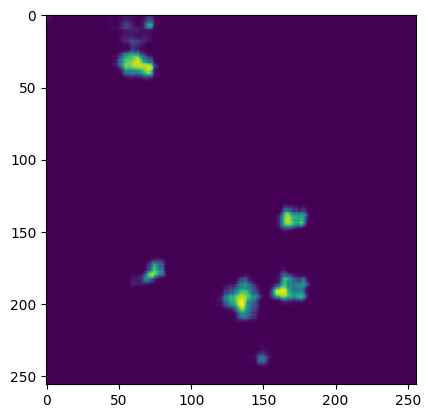

In [42]:
imshow(ans)